In [1]:
import sys
sys.path.append("asm_full_opt")
sys.path.append("data")

from system_psf import SystemPSF
from sv_convolution import SVConvolution
import config
import numpy as np
import matplotlib.pyplot as plt
import torch

Loaded batch: torch.Size([10, 28, 28])
Labels (first 10): [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]


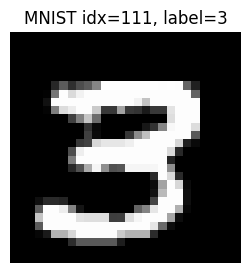

blocks shape: torch.Size([10, 49, 4, 4]) | blocks_one shape: torch.Size([49, 4, 4])


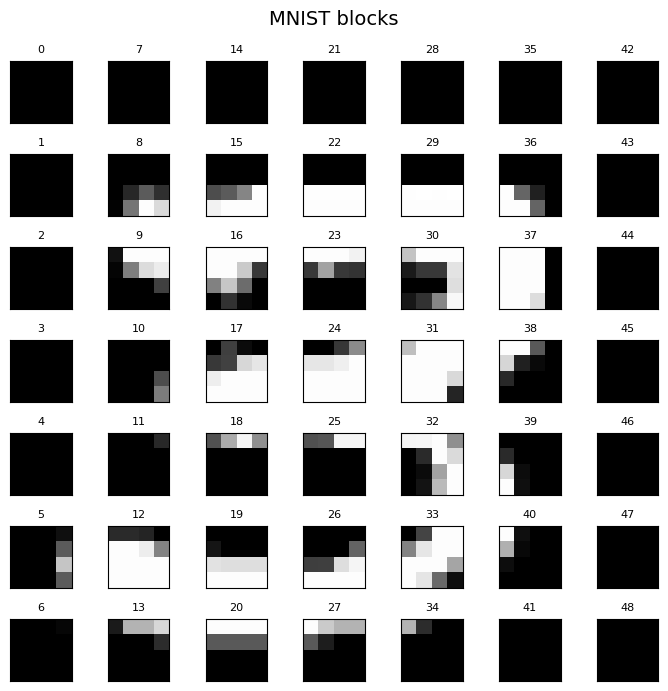

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

sv = SVConvolution(config)

# Load MNIST from your existing ./data folder (no download)
ds = MNIST(root="./data", train=True, download=False)

# Choose how many images to batch
N_batch = 10
idx0 = 111   # starting index

# Stack N_batch images into a batch
imgs = []
labels = []
for i in range(N_batch):
    x_pil, y = ds[idx0 + i]
    imgs.append(torch.from_numpy(np.array(x_pil)).float() / 255.0)
    labels.append(y)

imgs = torch.stack(imgs, dim=0)   # [N,28,28]

print("Loaded batch:", imgs.shape)
print("Labels (first 10):", labels[:10])

# Show ONE image from the batch
show_idx = 0
plt.figure(figsize=(3,3))
plt.imshow(imgs[show_idx], cmap="gray", vmin=0, vmax=1)
plt.title(f"MNIST idx={idx0+show_idx}, label={labels[show_idx]}")
plt.axis("off")
plt.show()

# Pass entire batch through block splitter
blocks = sv.images_to_blocks(imgs)   # NEW: [N, nBlocks, B, B]

# Pick one image's blocks to visualize
blocks_one = blocks[show_idx]        # [nBlocks, B, B]

B = sv.block_N
nBH = sv.H_obj // B
nBW = sv.W_obj // B

print("blocks shape:", blocks.shape, "| blocks_one shape:", blocks_one.shape)

# Visualize blocks in spatial layout (7x7)
fig, axes = plt.subplots(nBH, nBW, figsize=(7,7))
fig.suptitle("MNIST blocks", fontsize=14)

for bu in range(nBW):      # u-major ordering
    for bv in range(nBH):
        p = bu * nBH + bv
        ax = axes[bv, bu]
        ax.imshow(blocks_one[p].detach().cpu(), cmap="gray", vmin=0, vmax=1)  # [B,B]
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(str(p), fontsize=8)

plt.tight_layout()
plt.show()



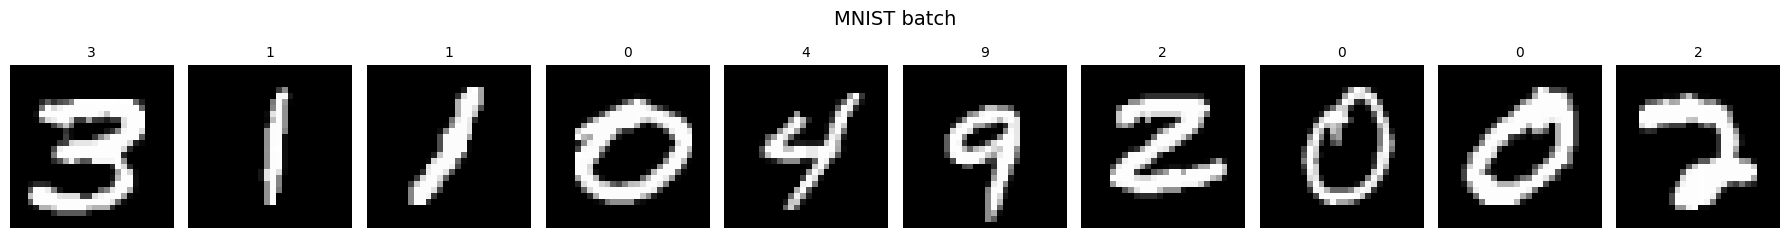

In [20]:
import matplotlib.pyplot as plt

N_show = imgs.shape[0]  # should be 10

fig, axes = plt.subplots(1, N_show, figsize=(1.8 * N_show, 2.5))
fig.suptitle("MNIST batch", fontsize=14)

for i in range(N_show):
    ax = axes[i]
    ax.imshow(imgs[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"{labels[i]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


Upsampled block shape: torch.Size([10, 49, 63, 63])


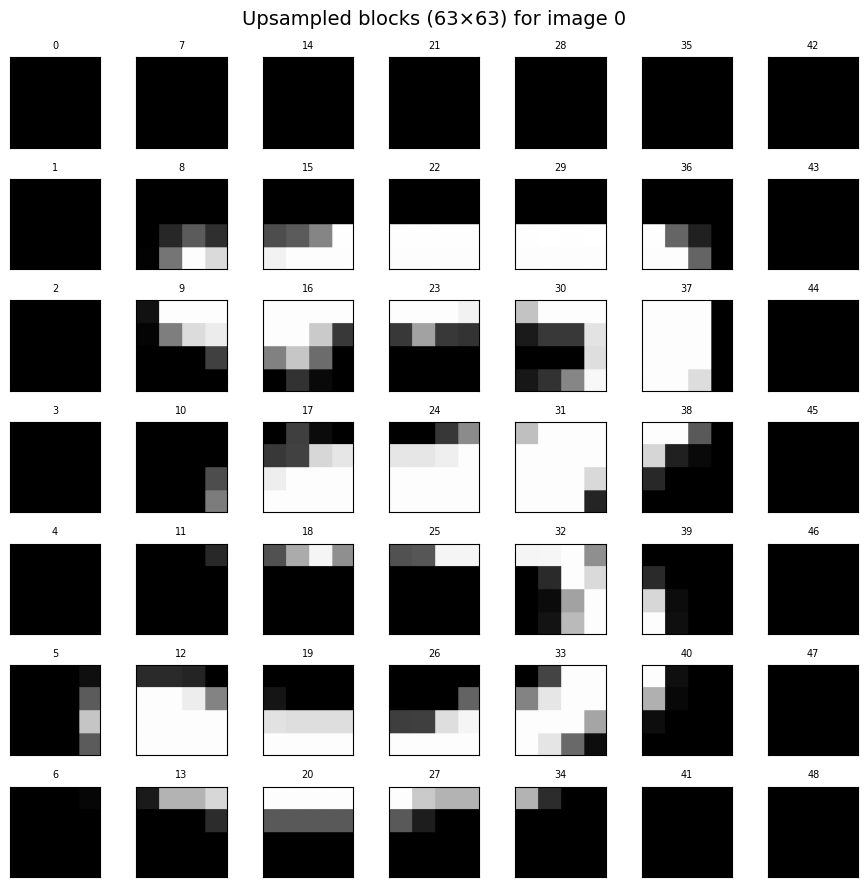

In [3]:
import matplotlib.pyplot as plt

# Pick which image in the batch to visualize
show_idx = 0

# NEW: blocks is [N, P, B, B] and upsample_blocks returns [N, P, upsample_N, upsample_N]
blocks_up = sv.upsample_blocks(blocks)        # [N, P, upsample_N, upsample_N]
blocks_up_one = blocks_up[show_idx]           # [P, upsample_N, upsample_N]

B = sv.block_N
nBH = sv.H_obj // B
nBW = sv.W_obj // B
upsample_N = blocks_up_one.shape[-1]          # upsample_N

print("Upsampled block shape:", blocks_up.shape)

# Plot upsampled blocks in spatial layout (7x7)
fig, axes = plt.subplots(nBH, nBW, figsize=(9, 9))
fig.suptitle(
    f"Upsampled blocks ({upsample_N}×{upsample_N}) for image {show_idx}",
    fontsize=14
)

for bu in range(nBW):      # u-major ordering
    for bv in range(nBH):
        p = bu * nBH + bv
        ax = axes[bv, bu]
        ax.imshow(
            blocks_up_one[p].detach().cpu(),  # [upsample_N, upsample_N]
            cmap="gray",
            vmin=0,
            vmax=1
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(p), fontsize=7)

plt.tight_layout()
plt.show()


In [4]:
imgs_up = sv.upsample_blocks(imgs.unsqueeze(1))
imgs_up = imgs_up.squeeze(-1)
imgs_up = imgs_up
print("Upsampled images shape:", imgs_up.shape)

Upsampled images shape: torch.Size([10, 1, 63, 63])


In [5]:
from psf_preprocess import PSFPreProcessor
system = SystemPSF(config, phase_init="hyperbolic", phase_noise_std=0.0, wrap_phase=False)

psf_stack, meta = system(strategy="block", block_size=4, normalize=True, return_meta=True)
print(psf_stack.shape)   

pre = PSFPreProcessor(config)
psf_crop = pre(psf_stack, system.pixel_map, system.gw, uv_samples=None, hfov_deg=None) 
print(psf_crop.shape) 

torch.Size([49, 255, 255])
torch.Size([49, 63, 63])


imgs: torch.Size([10, 28, 28])
imgs_up: torch.Size([10, 1, 63, 63])
psf_crop: torch.Size([49, 63, 63])
out: torch.Size([10, 125, 125])


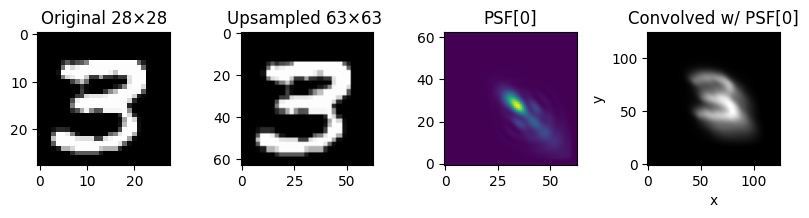

In [6]:
out = sv.convolve_with_first_psf(imgs_up.squeeze(1), psf_crop)

print("imgs:", imgs.shape)
print("imgs_up:", imgs_up.shape)
print("psf_crop:", psf_crop.shape)
print("out:", out.shape)

# Visualize one example
show_idx = 0
plt.figure(figsize=(8,3))

plt.subplot(1,4,1)
plt.imshow(imgs[show_idx].detach().cpu(), cmap="gray", vmin=0, vmax=1)
plt.title("Original 28×28")
# plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(imgs_up.squeeze(1)[show_idx].detach().cpu(), cmap="gray", vmin=0, vmax=1)
plt.title(f"Upsampled {upsample_N}×{upsample_N} ")
# plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(psf_crop[0, :, :].T.detach().cpu(), origin="lower")
plt.title("PSF[0]")


plt.subplot(1,4,4)
plt.imshow(out[show_idx].detach().cpu(), origin="lower", cmap="gray")
plt.title("Convolved w/ PSF[0]")
# plt.axis("off")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

In [7]:
k =0

print("imgs_up:", imgs_up.shape, imgs_up.dtype, imgs_up.device)
print("imgs_up min/max/sum:", imgs_up[k].min().item(), imgs_up[k].max().item(), imgs_up[k].sum().item())

print("psf_crop:", psf_crop.shape, psf_crop.dtype, psf_crop.device)
psf0 = psf_crop[0, :, :] if psf_crop.ndim == 3 else psf_crop
print("psf0 min/max/sum:", psf0.min().item(), psf0.max().item(), psf0.sum().item())
print("psf0 abs min/max/sum:", psf0.abs().min().item(), psf0.abs().max().item(), psf0.abs().sum().item())

print("out:", out.shape, out.dtype, out.device)
print("out min/max/sum:", out[k].min().item(), out[k].max().item(), out[k].sum().item())

imgs_up: torch.Size([10, 1, 63, 63]) torch.float32 cpu
imgs_up min/max/sum: 0.0 1.0 914.305908203125
psf_crop: torch.Size([49, 63, 63]) torch.float32 cpu
psf0 min/max/sum: 0.0 0.007565255276858807 0.8938159346580505
psf0 abs min/max/sum: 0.0 0.007565255276858807 0.8938159346580505
out: torch.Size([10, 125, 125]) torch.float32 cpu
out min/max/sum: 0.0 0.585888147354126 817.2210693359375


In [8]:
print("imgs_up:", imgs_up.shape, imgs_up.dtype, imgs_up.device)

imgs_up_rep = imgs_up.repeat(1, 49, 1, 1)  # [N,49,63,63]

print(imgs_up_rep.shape)

imgs_up: torch.Size([10, 1, 63, 63]) torch.float32 cpu
torch.Size([10, 49, 63, 63])


In [9]:
full_out = sv.convolve_blocks_with_matching_psfs(imgs_up_rep, psf_crop)

print("full_out:", full_out.shape, full_out.dtype, full_out.device)

full_out: torch.Size([10, 49, 125, 125]) torch.float32 cpu


Per-region conv output shape: torch.Size([49, 125, 125])


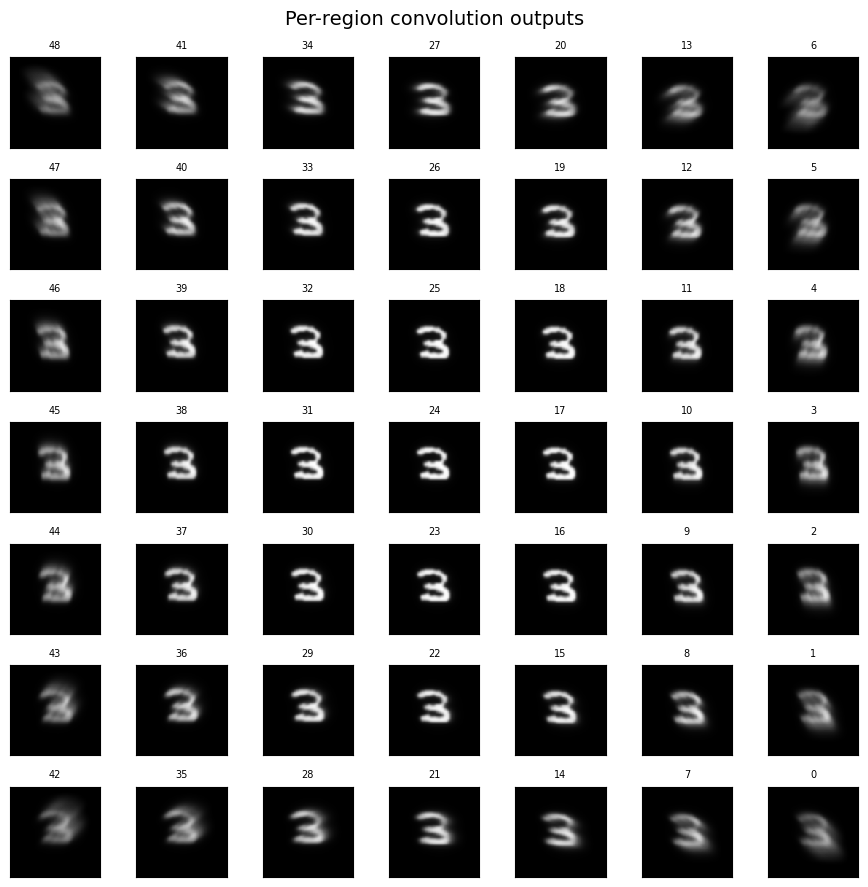

In [10]:
import matplotlib.pyplot as plt

# Pick which image in the batch to visualize
show_idx = 0

out_one = full_out[show_idx]   # [49, H_out, W_out]
P, H_out, W_out = out_one.shape

B = sv.block_N
nBH = sv.H_obj // B
nBW = sv.W_obj // B

print("Per-region conv output shape:", out_one.shape)

# Plot per-region convolution outputs in spatial layout (7x7)
fig, axes = plt.subplots(nBH, nBW, figsize=(9, 9))
fig.suptitle("Per-region convolution outputs", fontsize=14)

# Use auto-scaling per image so nothing looks black
vmax = out_one.max().item()
vmin = out_one.min().item()


for bi in range(nBH):          # block_v (rows)
    for bj in range(nBW):      # block_u (cols)

        # Lens inversion: flip both axes for display
        bi_disp = nBH - 1 - bi
        bj_disp = nBW - 1 - bj

        ax = axes[bi_disp, bj_disp]

        # Linear index (u-major)
        p = bj * nBH + bi

        img = out_one[p].detach().cpu()

        ax.imshow(
            img,                 # match PSF visualization convention
            origin="lower",
            cmap="gray",
            vmin=vmin,
            vmax=vmax,
            interpolation="nearest"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(p), fontsize=7)

plt.tight_layout()
plt.show()


In [11]:
full_out = sv.convolve_blocks_with_matching_psfs(blocks_up, psf_crop)

print("full_out:", full_out.shape, full_out.dtype, full_out.device)

full_out: torch.Size([10, 49, 125, 125]) torch.float32 cpu


Per-region conv output shape: torch.Size([49, 125, 125])


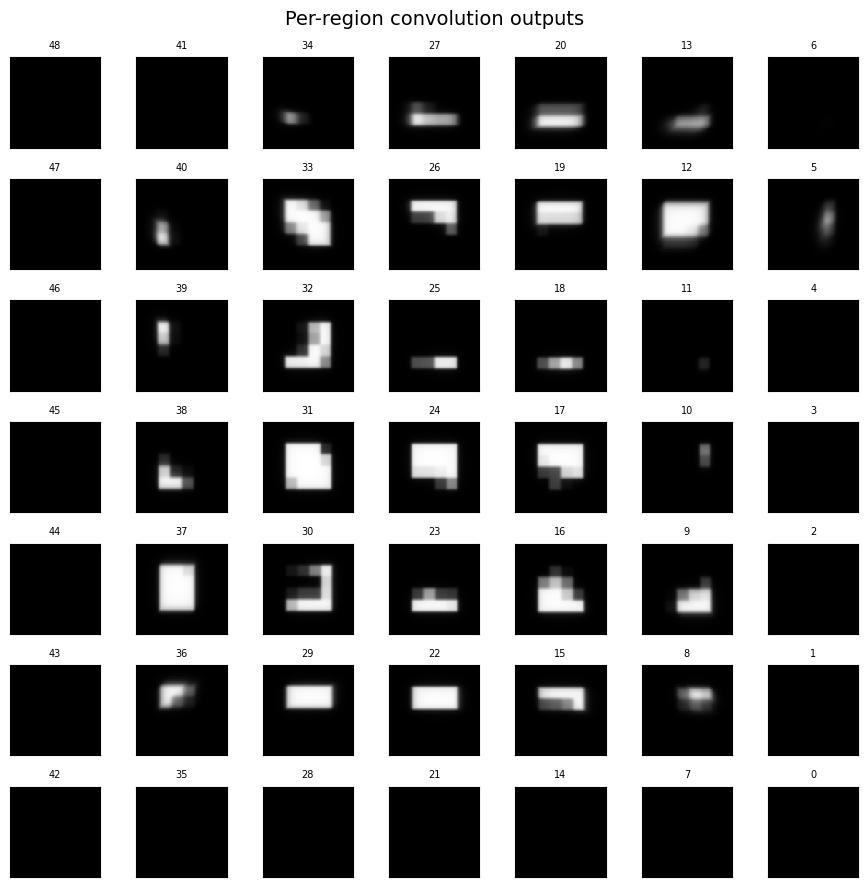

In [24]:
out_one = full_out[show_idx]   # [49, H_out, W_out]
P, H_out, W_out = out_one.shape

B = sv.block_N
nBH = sv.H_obj // B
nBW = sv.W_obj // B

print("Per-region conv output shape:", out_one.shape)

# Plot per-region convolution outputs in spatial layout (7x7)
fig, axes = plt.subplots(nBH, nBW, figsize=(9, 9))
fig.suptitle("Per-region convolution outputs", fontsize=14)

# Use auto-scaling per image so nothing looks black
vmax = out_one.max().item()
vmin = out_one.min().item()


for bi in range(nBH):          # block_v (rows)
    for bj in range(nBW):      # block_u (cols)

        # Lens inversion: flip both axes for display
        bi_disp = nBH - 1 - bi
        bj_disp = nBW - 1 - bj

        ax = axes[bi_disp, bj_disp]

        # Linear index (u-major)
        p = bj * nBH + bi

        img = out_one[p].detach().cpu()

        ax.imshow(
            img,                 # match PSF visualization convention
            origin="lower",
            cmap="gray",
            vmin=vmin,
            vmax=vmax,
            interpolation="nearest"
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(p), fontsize=7)

plt.tight_layout()
plt.show()


In [35]:
X = system.gw.X
Y = system.gw.Y

theta_x = system.gw.theta_x
theta_y = system.gw.theta_y 

from pixel_map import PixelMap
pm = PixelMap(config)
x_centers_T, y_centers_T = pm.angles_to_sensor_xy(theta_x, theta_y)


x_grid = -x_centers_T.reshape(7, 7)
x_grid_T = x_grid.T  
x_centers = x_grid_T.reshape(-1)

y_grid = y_centers_T.reshape(7, 7)
y_grid_T = y_grid.T
y_centers = y_grid_T.reshape(-1)



sensor_img shape: torch.Size([10, 255, 255])


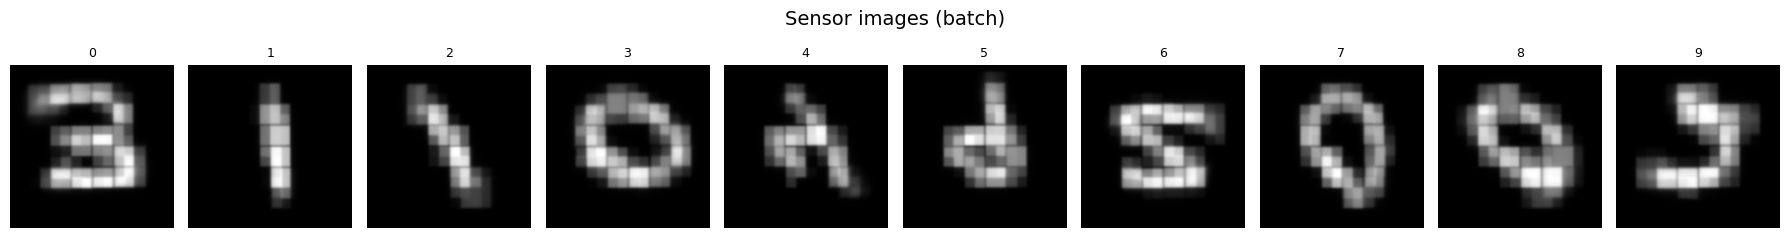

In [36]:
import matplotlib.pyplot as plt

# Splat per-region outputs onto sensor
sensor_img = sv.splat_blocks_to_sensor(
    X=X,
    Y=Y,
    x_centers=x_centers,
    y_centers=y_centers,
    block_out=full_out,
)

print("sensor_img shape:", sensor_img.shape)

fig, axes = plt.subplots(1, N_show, figsize=(1.8 * N_show, 2.5))
fig.suptitle("Sensor images (batch)", fontsize=14)

for i in range(N_show):
    ax = axes[i]
    im = ax.imshow(
        sensor_img[i].detach().cpu(),
        cmap="gray",
        origin="lower"
    )
    ax.set_title(f"{i}", fontsize=9)
    ax.axis("off")

# fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)

plt.tight_layout()
plt.show()

